## Appendix: Twitter Profile Classifier (Teacher, Non-Teacher)

### Last mod: Dec 30th, 2020

Input:
* coded-profiles.csv
    * 517 hand-coded Twitter user profiles for training data
* userdata.csv
    * user data from all Tweets in the study data to be predicted after classifier fit
    
Output:
* predictions.csv
    * classifications (teacher, non-teacher) for userdata.csv

In [31]:
from platform import python_version
print(python_version())

3.7.0


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, roc_auc_score
from nltk.corpus import stopwords

### Read in data and remove empty cases

In [3]:
df = pd.read_csv("coded-profiles.csv", encoding="ISO-8859-1")
df = df.dropna(subset=["Category"]) # drop cases without labels, file has a couple of empty rows

### Code Teacher as 1, remaining categories as 0

In [4]:
categories = set(df.Category)
categories.remove("Teacher")

for category in categories:
    df.loc[df["Category"] == category, "Category"] = "Not Teacher"

In [5]:
round(df.description.isnull().sum() / df.shape[0], 2) * 100 # 6% of coded profiles do not have a Twitter bio text

6.0

### For generating words that might distinguish between teachers and non-teachers, we looked at the most common words in Twitter user bios in our training sample.

In [6]:
des = df.description.dropna()
all_des = " ".join(list(des))

punctuation = '''!()-[]{};:'"\,<>./?@#$%^&*_|~'''
no_punctuation = ""
for char in all_des:
    if char not in punctuation:
        no_punctuation = no_punctuation + char

all_des = no_punctuation.lower()

d = {}

for word in all_des.split(" "):
    if word not in d:
        d[word] = 1
    else:
        d[word] += 1

tups = list(d.items())

tups.sort(key=lambda tup: tup[1], reverse=True) 

tups = [pair for pair in tups if pair[0] not in stopwords.words("english")]

print(tups[0:5]) # example results, first entry most likely results from trailing characters

[('', 442), ('science', 279), ('teacher', 234), ('educator', 83), ('school', 79)]


### For textual pre-processing of Twitter bio texts, we removed punctuation and converted texts to lower case. This is done for standardizing our keywords (see next cell, e.g., "k-12" to "k12" and "Teacher" to "teacher").

In [7]:
punctuation = '''!()-[]{};:'"\,<>./?@#$%^&*_|~'''

res = []

for description in df.description.values:

    no_punctuation = ""
    for char in str(description):
        if char not in punctuation:
            no_punctuation = no_punctuation + char
    
    res.append(no_punctuation.lower())

df.description = res

### Our classifier was based on binary variables indicating the presence or absence of the following keywords in Twitter bio texts

In [8]:
teacherwords = ["teacher", "teaching", "educator", "instructor", "k12", "k8", "k5"]
non_teacherwords = ["prof"]  

for word in teacherwords + non_teacherwords:
    res = []
    for text in list(df.description.values):
        if word in str(text):
            res.append(1)
        else:
            res.append(0)
    df[str("has_" + word)] = res

### We trained our classifier, a support-vector machine called SVC from sklearn.svm, on the following variables with the following hyperparameters and with a test set size of 10%:

In [9]:
labels = df.Category
training = df.drop(columns=["Category", "Code", "Description",
                           "screen_name", "description", "location",
                           "id", "handle", "full", "error", "url",
                           "name", "created", "protected",
                           "profileImageURL", "url", "cache_date",
                           "random_num", "n", "statusesCount", 
                           "followersCount", "friendsCount",
                           "favoritesCount", "listCount"])

In [10]:
print(training.columns)

Index(['has_teacher', 'has_teaching', 'has_educator', 'has_instructor',
       'has_k12', 'has_k8', 'has_k5', 'has_prof'],
      dtype='object')


In [11]:
X_train, X_test, y_train, y_test = train_test_split(training, labels, test_size = 0.1, random_state = 0)

In [12]:
sc = StandardScaler() 
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test)

In [13]:
classifier = SVC(kernel = 'rbf', random_state = 0, gamma = 0.5) 
classifier.fit(X_train, y_train) 

y_pred = classifier.predict(X_test)
y_pred_prob = classifier.decision_function(X_test) # get probabilities for ROC curve

### We evaluated our classifier through a range of indices

1) Out-of-sample accuracy and confusion matrix, 10% test split

In [14]:
cm = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=['Teacher', 'Not Teacher']), 
    index=['test:teacher', 'test:non-teacher'], 
    columns=['pred:teacher', 'pred:non-teacher']
)
print(cm, "\n")
print(round(accuracy_score(y_test, y_pred) * 100, 2))

                  pred:teacher  pred:non-teacher
test:teacher                22                 2
test:non-teacher             6                22 

84.62


2) ROC curve and AUC value

In [15]:
# Converting out of sample test set to correct data type
y_test[y_test=="Teacher"] = 1
y_test[y_test=="Not Teacher"] = 0

y_test = np.array(y_test, dtype="int")

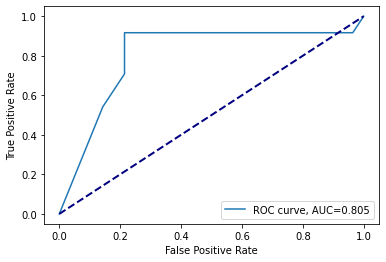

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.plot(fpr, tpr, label="ROC curve, AUC="+str(round(auc, 3)))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

3) Cohen's Kappa (after predicting the whole training data set with the fitted classifier)

In [17]:
y_test = df.Category
y_pred = classifier.predict(training)

result = pd.concat([y_test, pd.Series(y_pred)], axis=1)
result.columns = ["label", "prediction"]

print(round(cohen_kappa_score(result.label, result.prediction), 3))

0.612


4) Several additional measures for classification model diagnostics on full training set

In [18]:
precision, recall, fscore, support = precision_recall_fscore_support(result.label, result.prediction, 
                                                                     labels=["Teacher", "Not Teacher"])

print('Model Diagnostics Summary on Full Training Set for Classification as Teacher\n')
print('precision:\t{}'.format(round(precision[0], 3)))
print('recall:\t\t{}'.format(round(recall[0], 3)))
print('fscore:\t\t{}'.format(round(fscore[0], 3)))
print('support:\t{}'.format(support[0]))

Model Diagnostics Summary on Full Training Set for Classification as Teacher

precision:	0.716
recall:		0.922
fscore:		0.806
support:	230


### The remaining part of the documentation showcases pre-processing and application of our fitted classifier on the study sample (userdata.csv).

In [19]:
users = pd.read_csv("userdata.csv", encoding="ISO-8859-1")

In [20]:
users = users.drop(columns=["account_created_at",
                           "verified", "profile_url", "profile_expanded_url",
                           "account_lang", "profile_banner_url", "profile_background_url",
                           "profile_image_url", "Unnamed: 0", "user_id", "screen_name",
                           "name", "location", "url", "protected"])

In [21]:
users = users.rename(columns={"statuses_count": "statusesCount",
                      "followers_count": "followersCount",
                      "friends_count": "friendsCount",
                      "favourites_count": "favoritesCount",
                      "listed_count": "listCount"})

In [22]:
users = users.drop(columns=["statusesCount", 
                           "followersCount", "friendsCount",
                           "favoritesCount", "listCount"])

In [23]:
punctuation = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

res = []

for description in users.description.values:

    no_punctuation = ""
    for char in str(description):
        if char not in punctuation:
            no_punctuation = no_punctuation + char
    
    res.append(no_punctuation.lower())

users.description = res

In [24]:
teacherwords = ["teacher", "teaching", "educator", "instructor", "k12", "k8", "k5"]
non_teacherwords = ["prof"]  

for word in teacherwords + non_teacherwords:
    res = []
    for text in list(users.description.values):
        if word in str(text):
            res.append(1)
        else:
            res.append(0)
    users[str("has_" + word)] = res

In [25]:
users = users.drop(columns="description")

In [26]:
y_pred = classifier.predict(users)

In [27]:
predictions = pd.DataFrame(y_pred)
predictions.columns = ["prediction_by_keywords"]

In [28]:
predictions = predictions.replace("Teacher", 1)
predictions = predictions.replace("Not Teacher", 0)

In [29]:
predictions.to_csv("predictions.csv", index=False)

In [30]:
predictions.prediction_by_keywords.value_counts()  # overview on predictions (Tweet level)

0    346613
1    224765
Name: prediction_by_keywords, dtype: int64